Calculate and plot taus per area:

full signal (fit all ACFs from units from that area):
1. ACF full
2. iSTTC full
   
trial average style:
1. Pearsonr trial avg
2. iSTTC trial avg
3. iSTTC trial concat

For every unit I have 100 sampling iterations of 40 trials. For the trial average there are 2 ways of calculating one point per area:
1. Take a mean over 100 ACFs and use it as a unit ACF.
2. Pull all indivudual ACFs together
3. Take one sampling iteration (this one is used in current figure draft!) - it resembles the experimenatal datasets.

ACFs with NaNs are removed as preprocessing.

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [71]:
# True - calc and plot, False only plot
calc_taus = True
save_taus = False
save_fig = True

In [38]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_, verbose_=False):
    rows_with_nans_df = acf_df_[acf_df_.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    if n_rows_with_nan > 0:
        print(f'N rows with NaNs {n_rows_with_nan}')

    acf_df_.dropna(inplace=True)
    
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    if verbose_:
        print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt,
            'n_acfs': len(acf_df_)}

def get_method_tau_dict(areas_, acf_df_, acf_cols_, verbose_=False):
    taus_dict = {}
    for area in areas_:
        if verbose_:
            print(f'processing area {area}')
        acf_df_area = acf_df_.query('ecephys_structure_acronym == @area').copy()
        if verbose_:
            print(f'N units for brain area {area}: {len(acf_df_area)}')
        taus_dict[area] = calc_population_tau_2d(acf_df_area, acf_cols_, 2, func_single_exp_monkey)
    return taus_dict

In [29]:
min_to_keep = 20

dataset_folder = project_folder_path + 'results\\mice\\dataset\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

### Load data (or calc)

In [39]:
def get_taus_for_df(acf_full_df_file_):
    n_lags = 20
    acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
    # print('acf_cols {}'.format(acf_cols))

    acf_df = pd.read_pickle(acf_full_df_file_)
    n_rows_with_nan = len(acf_df[acf_df.isna().any(axis=1)])
    # print(f'n_rows_with_nan acf_df {n_rows_with_nan}')

    brain_areas = acf_df['ecephys_structure_acronym'].unique()
    # print(f'brain_areas {brain_areas}')
    
    acf_taus_dict = get_method_tau_dict(brain_areas, acf_df, acf_cols)

    return acf_taus_dict

In [40]:
area_taus_dict = {'acf_full_1': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_1min\\acf_full_50ms_20lags_' + str(1) + 'min_df.pkl'), 
                  'isttc_full_1': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_1min\\isttc_full_50ms_20lags_' + str(1) + 'min_df.pkl'),
                  'acf_full_5': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_5min\\acf_full_50ms_20lags_' + str(5) + 'min_df.pkl'), 
                  'isttc_full_5': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_5min\\isttc_full_50ms_20lags_' + str(5) + 'min_df.pkl'),
                  'acf_full_10': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_10min\\acf_full_50ms_20lags_' + str(10) + 'min_df.pkl'), 
                  'isttc_full_10': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_10min\\isttc_full_50ms_20lags_' + str(10) + 'min_df.pkl'),
                  'acf_full_20': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_20min\\acf_full_50ms_20lags_' + str(20) + 'min_df.pkl'), 
                  'isttc_full_20': get_taus_for_df(acf_full_df_file_ = dataset_folder + 'cut_20min\\isttc_full_50ms_20lags_' + str(20) + 'min_df.pkl'),}

N rows with NaNs 8
N rows with NaNs 12
N rows with NaNs 5
N rows with NaNs 8
N rows with NaNs 65
N rows with NaNs 3


In [46]:
with open(dataset_folder + 'cut_30min\\area_taus_dict.json', 'r') as f:
    area_taus_dict_30 = json.load(f)

area_taus_dict_30

{'acf_full': {'VISam': {'tau_ms': 336.07320279984594,
   'tau_lower_ms': 299.7883635744778,
   'tau_upper_ms': 372.3580420252141,
   'fit_r_squared': 0.1690827353887845,
   'explained_var': 0.1690827353887845,
   'popt': [0.15066313822749405, 6.721464055996918, 0.35991094161797405],
   'n_acfs': 912},
  'LP': {'tau_ms': 257.53315535707674,
   'tau_lower_ms': 232.53166108308338,
   'tau_upper_ms': 282.53464963107007,
   'fit_r_squared': 0.21579454321067337,
   'explained_var': 0.21579454321067415,
   'popt': [0.19342958660101656, 5.1506631071415345, 0.23470055931078737],
   'n_acfs': 599},
  'VISp': {'tau_ms': 319.66687594979885,
   'tau_lower_ms': 295.8336673894851,
   'tau_upper_ms': 343.50008451011263,
   'fit_r_squared': 0.25481240042972364,
   'explained_var': 0.25481240042972364,
   'popt': [0.18047514672563475, 6.393337518995977, 0.20499504573309316],
   'n_acfs': 1063},
  'VISl': {'tau_ms': 309.8334693807622,
   'tau_lower_ms': 279.6725253656186,
   'tau_upper_ms': 339.994413395

In [41]:
def get_plot_df(acf_dict, areas, method):
    tau = [acf_dict.get(c, {'tau_ms': np.nan})['tau_ms'] for c in areas]
    tau_lower = [acf_dict.get(c, {'tau_lower_ms': np.nan})['tau_lower_ms'] for c in areas]
    tau_upper = [acf_dict.get(c, {'tau_upper_ms': np.nan})['tau_upper_ms'] for c in areas]
    
    plot_df = pd.DataFrame({'area': areas, 
                                     'tau': tau,
                                     'tau_lower': tau_lower, 
                                     'tau_upper': tau_upper, 
                                     'method': method})
    return plot_df

In [54]:
tau_acf_full_30_df = get_plot_df(area_taus_dict_30['acf_full'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_30_df['duration_min'] = 30
tau_acf_full_30_df['tau_diff'] = tau_acf_full_30_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_30_df = get_plot_df(area_taus_dict_30['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_30_df['duration_min'] = 30
tau_isttc_full_30_df['tau_diff'] = tau_isttc_full_30_df['tau'] - tau_isttc_full_30_df['tau']

tau_acf_full_1_df = get_plot_df(area_taus_dict['acf_full_1'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_1_df['duration_min'] = 1
tau_acf_full_1_df['tau_diff'] = tau_acf_full_1_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_1_df = get_plot_df(area_taus_dict['isttc_full_1'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_1_df['duration_min'] = 1
tau_isttc_full_1_df['tau_diff'] = tau_isttc_full_1_df['tau'] - tau_isttc_full_30_df['tau']

tau_acf_full_5_df = get_plot_df(area_taus_dict['acf_full_5'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_5_df['duration_min'] = 5
tau_acf_full_5_df['tau_diff'] = tau_acf_full_5_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_5_df = get_plot_df(area_taus_dict['isttc_full_5'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_5_df['duration_min'] = 5
tau_isttc_full_5_df['tau_diff'] = tau_isttc_full_5_df['tau'] - tau_isttc_full_30_df['tau']

tau_acf_full_10_df = get_plot_df(area_taus_dict['acf_full_10'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_10_df['duration_min'] = 10
tau_acf_full_10_df['tau_diff'] = tau_acf_full_10_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_10_df = get_plot_df(area_taus_dict['isttc_full_10'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_10_df['duration_min'] = 10
tau_isttc_full_10_df['tau_diff'] = tau_isttc_full_10_df['tau'] - tau_isttc_full_30_df['tau']

tau_acf_full_20_df = get_plot_df(area_taus_dict['acf_full_20'], brain_areas_axes_ticks, 'acf_full')
tau_acf_full_20_df['duration_min'] = 20
tau_acf_full_20_df['tau_diff'] = tau_acf_full_20_df['tau'] - tau_acf_full_30_df['tau']
tau_isttc_full_20_df = get_plot_df(area_taus_dict['isttc_full_20'], brain_areas_axes_ticks, 'isttc_full')
tau_isttc_full_20_df['duration_min'] = 20
tau_isttc_full_20_df['tau_diff'] = tau_isttc_full_20_df['tau'] - tau_isttc_full_30_df['tau']

tau_df = pd.concat([tau_acf_full_1_df, tau_isttc_full_1_df, tau_acf_full_5_df, tau_isttc_full_5_df, 
                    tau_acf_full_10_df, tau_isttc_full_10_df, tau_acf_full_20_df, tau_isttc_full_20_df,
                    tau_acf_full_30_df, tau_isttc_full_30_df])
tau_df['abs_tau_diff'] = np.abs(tau_df['tau_diff'])
tau_df.reset_index(inplace=True, drop=True)

tau_df

,area,tau,tau_lower,tau_upper,method,duration_min,tau_diff,abs_tau_diff
0,LGd,327.231022,274.988990,379.473055,acf_full,1,-6.434095,6.434095
1,VISp,327.158924,296.657015,357.660833,acf_full,1,7.492048,7.492048
2,VISl,339.874384,296.148625,383.600144,acf_full,1,30.040915,30.040915
3,VISrl,267.143260,232.913419,301.373100,acf_full,1,35.182874,35.182874
4,LP,294.893259,262.172497,327.614021,acf_full,1,37.360103,37.360103
...,...,...,...,...,...,...,...,...
75,VISrl,241.179435,216.215517,266.143354,isttc_full,30,0.000000,0.000000
76,LP,256.180645,230.539597,281.821694,isttc_full,30,0.000000,0.000000
77,VISal,317.408137,287.245163,347.571111,isttc_full,30,0.000000,0.000000
78,VISpm,355.741012,307.295803,404.186220,isttc_full,30,0.000000,0.000000


In [ ]:
# if save_taus:
#     class NumpyEncoder(json.JSONEncoder):
#         def default(self, obj):
#             if isinstance(obj, np.ndarray):
#                 return obj.tolist()  # Convert ndarray to list
#             return super().default(obj)
    
#     with open(dataset_folder + 'area_taus_dict.json', 'w') as f:
#         json.dump(area_taus_dict, f, cls=NumpyEncoder, indent=4)  

In [ ]:
# with open(dataset_folder + 'area_taus_dict.json', 'r') as f:
#     area_taus_dict = json.load(f)

### Plots

In [59]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'

colors = [color_acf_full, color_isttc_full]

brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

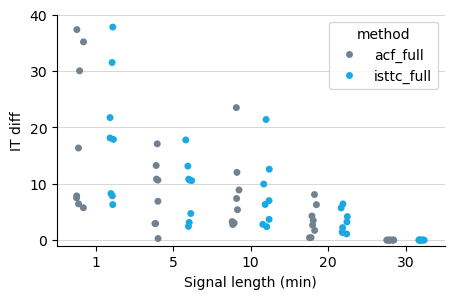

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3), sharey=False)

sns.stripplot(data=tau_df, x='duration_min', y='abs_tau_diff', hue='method', palette=colors, dodge=True, jitter=True, alpha=1, ax=axes)
axes.grid(True, which="both", axis='y', linestyle="-", linewidth=0.5, alpha=0.7)

axes.set_ylabel('IT diff')
axes.set_xlabel('Signal length (min)')

axes.set_ylim([-1, 40])

sns.despine(ax=axes)

if save_fig:
    plt.savefig(fig_folder + 'signal_len_tau.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'signal_len_tau.svg' , bbox_inches='tight')